<a href="https://www.kaggle.com/code/kripeshnihure/t5-finetuned?scriptVersionId=225949609" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install datasets

In [2]:
import pandas as pd
from datasets import Dataset
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

In [3]:
splits = {'train': 'synthetic_text_to_sql_train.snappy.parquet', 'test': 'synthetic_text_to_sql_test.snappy.parquet'}
train_df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["test"])

train_df.head(1)

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."


In [4]:
train_df.columns

Index(['id', 'domain', 'domain_description', 'sql_complexity',
       'sql_complexity_description', 'sql_task_type',
       'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql',
       'sql_explanation'],
      dtype='object')

In [5]:
train_df.value_counts('sql_complexity'),test_df.value_counts('sql_complexity')

(sql_complexity
 basic SQL           48466
 aggregation         22015
 single join         14932
 subqueries           6719
 window functions     3596
 multiple_joins       2949
 set operations       1050
 CTEs                  273
 Name: count, dtype: int64,
 sql_complexity
 basic SQL           2869
 aggregation         1304
 single join          886
 subqueries           386
 window functions     196
 multiple_joins       139
 set operations        51
 CTEs                  20
 Name: count, dtype: int64)

In [6]:
# desired_samples = {
#     "basic SQL": 12500,
#     "aggregation": 12500,
#     "single join": 12750,
#     "subqueries": 5000,
#     "window functions": 3500,
#     "multiple_joins": 2500,
#     "set operations": 1000,  
#     "CTEs": 250 
# }


# # Perform stratified sampling
# stratified_df = pd.DataFrame()  
# for category, n_samples in desired_samples.items():
#     subset = train_df[train_df['sql_complexity'] == category]
#     sampled_subset = subset.sample(n=n_samples, random_state=42) 
#     stratified_df = pd.concat([stratified_df, sampled_subset])

# # Shuffle final stratified dataset
# train_df = stratified_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
train_df.value_counts('sql_complexity')

sql_complexity
basic SQL           48466
aggregation         22015
single join         14932
subqueries           6719
window functions     3596
multiple_joins       2949
set operations       1050
CTEs                  273
Name: count, dtype: int64

In [8]:
test_df = test_df.sample(2000)
test_df.value_counts('sql_complexity')

sql_complexity
basic SQL           980
aggregation         452
single join         298
subqueries          134
window functions     69
multiple_joins       45
set operations       19
CTEs                  3
Name: count, dtype: int64

In [9]:
# Retain only necessary columns
train_df = train_df[['sql_prompt', 'sql_context', 'sql']]
test_df = test_df[['sql_prompt', 'sql_context', 'sql']]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sql_prompt   100000 non-null  object
 1   sql_context  100000 non-null  object
 2   sql          100000 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [10]:
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)
train_data['sql_context'][0]

"CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');"

In [11]:
import re

def clean_schema(schema):
    """Formats the schema into a readable structure, ignoring INSERT statements."""
    tables = re.findall(r"CREATE TABLE (\w+) \((.*?)\);", schema, re.DOTALL)
    formatted_schema = []

    for table_name, columns in tables:
        formatted_columns = ", ".join(col.split()[0] for col in columns.split(","))
        formatted_schema.append(f"{table_name}: {formatted_columns}")

    return "\n".join(formatted_schema)

# Apply clean_schema to each row
train_data = train_data.map(lambda x: {"sql_context": clean_schema(x["sql_context"])})
test_data = test_data.map(lambda x: {"sql_context": clean_schema(x["sql_context"])})

# Check the first cleaned schema
print(train_data[0]["sql_context"])


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

salesperson: salesperson_id, name, region
timber_sales: sales_id, salesperson_id, volume, sale_date


In [12]:
n=15
print(train_df.sql_context[n], train_data[n]['sql_context'],sep='\n')

CREATE TABLE mammals (id INT, name VARCHAR(255), conservation_status VARCHAR(255), year INT); CREATE TABLE birds (id INT, name VARCHAR(255), conservation_status VARCHAR(255), year INT); CREATE VIEW combined AS SELECT 'Mammals' AS animal_group, * FROM mammals UNION ALL SELECT 'Birds', * FROM birds;
mammals: id, name, conservation_status, year
birds: id, name, conservation_status, year


In [13]:
# Load the tokenizer and model
model_name = "t5-small"  # Use "t5-base" for better performance
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

input_texts = []
# Tokenization function
def preprocess_data(queries):
    input_texts = [
        f"Translate this english language query into SQL: \"{query}\" considering the database tables context: {ctx}" 
        for ctx, query in zip(queries["sql_context"], queries["sql_prompt"])
    ]
    target_texts = [sql for sql in queries["sql"]]

    inputs = tokenizer(input_texts, padding="max_length", truncation=True, max_length=256)
    targets = tokenizer(target_texts, padding="max_length", truncation=True, max_length=256)

    targets["input_ids"] = [
        [(t if t != tokenizer.pad_token_id else -100) for t in target] for target in targets["input_ids"]
    ]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"]
    }

# Preprocess dataset
train_data = train_data.map(preprocess_data, batched=True)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [14]:
train_data.shape

(100000, 6)

In [15]:
# Split into train & validation sets
split_dataset = train_data.train_test_split(test_size=0.20, seed=42)
train_data = split_dataset["train"]
val_data = split_dataset["test"]

# Training arguments 
training_args = TrainingArguments(
    output_dir="./t5_sql_model",
    eval_strategy="epoch",
    save_strategy="epoch", 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=3e-4,  
    weight_decay=0.01,
    logging_dir="./logs",
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

In [16]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("API_KEY")

# Log in with your WandB API key
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nkripesh0 (nkripesh0-pulchowk-campus). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Start Training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250305_174611-2aq80h09
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./t5_sql_model
wandb: ⭐️ View project at https://wandb.ai/nkripesh0-pulchowk-campus/huggingface
wandb: 🚀 View run at https://wandb.ai/nkripesh0-pulchowk-campus/huggingface/runs/2aq80h09
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.412600,0.337650
2,0.343200,0.285390
3,0.302200,0.261411
4,0.274700,0.249205
5,0.259100,0.245373


TrainOutput(global_step=50000, training_loss=0.3589439404296875, metrics={'train_runtime': 9703.3807, 'train_samples_per_second': 41.223, 'train_steps_per_second': 5.153, 'total_flos': 2.70683602944e+16, 'train_loss': 0.3589439404296875, 'epoch': 5.0})

In [18]:
training_logs = trainer.state.log_history

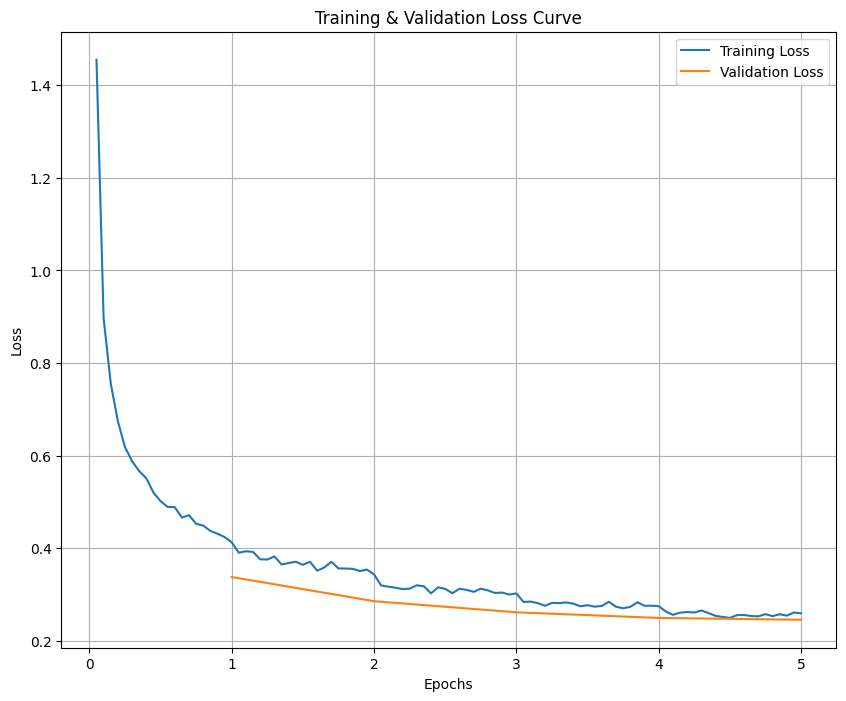

In [19]:
import matplotlib.pyplot as plt

epochs = [log['epoch'] for log in training_logs if 'loss' in log]
train_losses = [log['loss'] for log in training_logs if 'loss' in log]
eval_epochs = [log['epoch'] for log in training_logs if 'eval_loss' in log]
eval_losses = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]


plt.figure(figsize=(10, 8))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(eval_epochs, eval_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

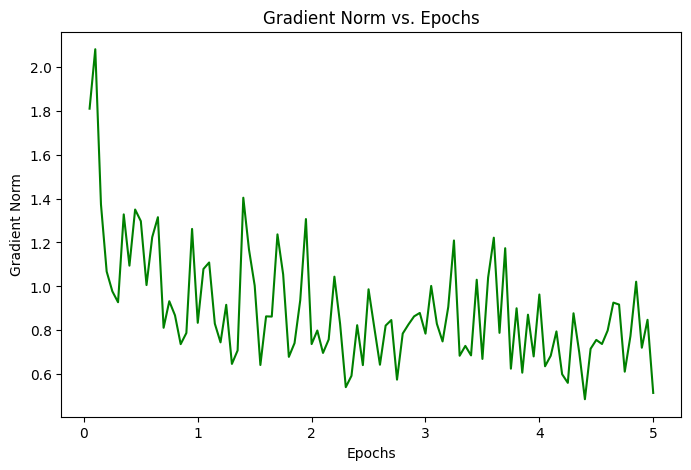

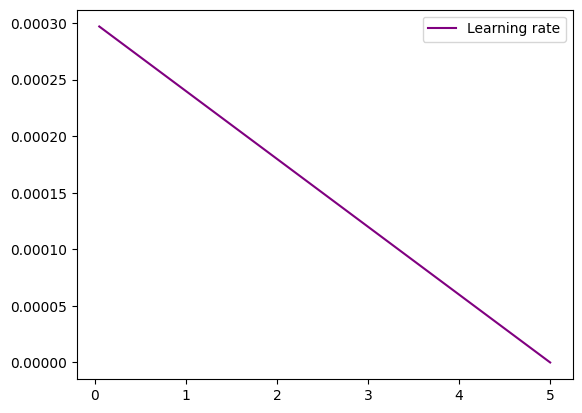

In [20]:
grad_norms = [log['grad_norm'] for log in training_logs if 'grad_norm' in log]
steps = [log['step'] for log in training_logs]
learning_rates = [log['learning_rate'] for log in training_logs if 'learning_rate' in log]

plt.figure(figsize=(8,5))
plt.plot(epochs, grad_norms, linestyle="-", color="g",label='Gradient norm')
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm vs. Epochs")
plt.show()

plt.plot(epochs, learning_rates, linestyle="-", color="purple",label='Learning rate')
plt.legend()
plt.show()

In [21]:
# Save the fine-tuned model
model.save_pretrained("t5_sql_model")
tokenizer.save_pretrained("t5_sql_model")

print("✅ Fine-tuning complete!")


✅ Fine-tuning complete!


In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
# Loading the fine-tuned model
model_name = "/kaggle/working/t5_sql_model"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


In [23]:
# Inference function 
def generate_sql(query, context):
    input_text = f"Translate this query in english: \"{query}\" to SQL considering the database tables: {context}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    # Using beam search and increased max_length for better results
    output_ids = model.generate(input_ids, max_length=256, num_beams=5, early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [24]:
query = "Find all customers who placed orders in the last 30 days, along with their contact information and the total value of their orders."
context = "Customers:cust_ID, name, contact_number, Orders:order_ID, cust_ID, order_value"
sql_query = generate_sql(query, context)
print(sql_query)

SELECT Customers.name, Customers.contact_number, SUM(Customers.order_value) as total_value FROM Customers INNER JOIN Orders ON Customers.cust_ID = Orders.cust_ID WHERE Orders.order_date >= DATEADD(day, -30, GETDATE()) GROUP BY Customers.cust_ID, Customers.contact_number;


In [25]:
from tqdm import tqdm

# Prepare predictions and references
predictions = []
references = []
for sample in tqdm(test_data):
    context = sample["sql_context"] 
    query = sample["sql_prompt"]  
    actual_sql = sample["sql"]  
    
    # Generate SQL using model
    generated_sql = generate_sql(query, context)
    
    # Append predictions and references
    predictions.append(generated_sql)
    references.append([actual_sql])

100%|██████████| 2000/2000 [53:33<00:00,  1.61s/it]


In [26]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00


In [27]:
import sacrebleu

# Compute BLEU score
bleu = sacrebleu.corpus_bleu(predictions, references)
scores = bleu.precisions
scores.append(bleu.score)
bleu_scores = pd.DataFrame({
    'Metric': ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','BLEU-overall'],
    'Initial_Score': scores
})
bleu_scores

,Metric,Initial_Score
0,BLEU-1,87.804878
1,BLEU-2,60.000000
2,BLEU-3,38.461538
3,BLEU-4,21.052632
4,BLEU-overall,45.446531
